# Fine-tune Deepseek-R1

- Fine-Tune DeepSeek R1 1.5B on Free GCP Colab T4: A Hands-On Guide with LoRA, [link](https://www.linkedin.com/pulse/fine-tune-deepseek-r1-15b-free-gcp-colab-t4-hands-on-konathala-phd--4bluf/)
- SFT Trainer [link](https://huggingface.co/docs/trl/en/sft_trainer)

## Installation

In [ ]:
# install the necessary packages
! pip install transformers datasets peft torch trl bitsandbytes

In [ ]:
from google.colab import userdata
HF_TOKEN = userdata.get('HF_TOKEN')

## Imports

In [ ]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer

# Define the model name
# model_name = "Qwen/Qwen2.5-0.5B"
# model_name = "Qwen/Qwen2.5-1.5B"
# model_name = "Qwen/Qwen2.5-1.5B-Instruct"
# model_name = "deepseek-ai/DeepSeek-R1-Distill-Qwen-0.5B"
model_name = "deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B"
# model_name = "deepseek-ai/DeepSeek-R1-Distill-Qwen-7B"
# model_name = "deepseek-ai/DeepSeek-R1-Distill-Llama-70B" # requires memory

# Load pre-trained model & tokenizer
model = AutoModelForCausalLM.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Move model to GPU if available
device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)

config.json:   0%|          | 0.00/681 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/988M [00:00<?, ?B/s]

Sliding Window Attention is enabled but not implemented for `sdpa`; unexpected results may be encountered.


generation_config.json:   0%|          | 0.00/138 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/7.23k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/7.03M [00:00<?, ?B/s]

## Data Type 1: Generate Domain-specific Document

In [ ]:
text = """
user_prompt with score 3. userprompt2 with score 2.
Artificial Intelligence (AI) is transforming industries across the globe. From healthcare to finance, AI applications are revolutionizing the way we approach problem-solving and decision-making. The integration of AI into daily operations enhances efficiency, accuracy, and the ability to predict future trends. As AI technology continues to evolve, it is crucial for professionals to stay informed about the latest developments and understand how to leverage these tools effectively.
"""

### Convert Text Data into HuggingFace Data

In [ ]:
from datasets import Dataset

# Split the text into sentences for better learning
sentences = text.split(". ")

# Create a Hugging Face dataset
dataset = Dataset.from_dict({"text": sentences})

Examine the data schema

In [ ]:
print(type(dataset))

<class 'datasets.arrow_dataset.Dataset'>


In [ ]:
dataset

Dataset({
    features: ['text'],
    num_rows: 5
})

### Setup Tokenizer

In [ ]:
def preprocess_function(examples, key='text'):
    inputs = tokenizer(
        examples[key], truncation=True, padding="max_length", max_length=512
    )

    # Labels must be a shifted version of input_ids for causal LM training
    inputs["labels"] = inputs["input_ids"].copy()
    return inputs

# Apply tokenization
tokenized_dataset = dataset.map(preprocess_function, batched=True)

Map:   0%|          | 0/5 [00:00<?, ? examples/s]

In [ ]:
tokenized_dataset

Dataset({
    features: ['text', 'input_ids', 'attention_mask', 'labels'],
    num_rows: 5
})

In [ ]:
tokenized_dataset['text']

['\nuser_prompt with score 3',
 'userprompt2 with score 2.\nArtificial Intelligence (AI) is transforming industries across the globe',
 'From healthcare to finance, AI applications are revolutionizing the way we approach problem-solving and decision-making',
 'The integration of AI into daily operations enhances efficiency, accuracy, and the ability to predict future trends',
 'As AI technology continues to evolve, it is crucial for professionals to stay informed about the latest developments and understand how to leverage these tools effectively.\n']

## Data Type 2: Generate Domain-specific Document: Real Dataset

In [ ]:
from datasets import load_dataset

# dataset = load_dataset("FreedomIntelligence/medical-o1-reasoning-SFT", "en", split="train[0:100]", trust_remote_code=True)
# dataset = load_dataset("FreedomIntelligence/medical-o1-reasoning-SFT", "en", split="train", trust_remote_code=True)
dataset = load_dataset("eagle0504/openai-gsm8k-enhanced-using-together-ai-deepseek-train8k-test1k-v1")

README.md:   0%|          | 0.00/2.89k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/5.35M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/417k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/7473 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1319 [00:00<?, ? examples/s]

In [ ]:
ds_train = dataset["train"]
ds_train

Dataset({
    features: ['question', 'answer', 'cot'],
    num_rows: 7473
})

In [ ]:
ds_train[0]

{'question': 'Natalia sold clips to 48 of her friends in April, and then she sold half as many clips in May. How many clips did Natalia sell altogether in April and May?',
 'answer': 'Natalia sold 48/2 = <<48/2=24>>24 clips in May.\nNatalia sold 48+24 = <<48+24=72>>72 clips altogether in April and May.\n#### 72',
 'cot': "<think>To solve the problem, we need to determine the total number of clips Natalia sold in April and May. Here's the reasoning:\n\n1. **Clips sold in April**: Natalia sold 48 clips in April. This is given directly in the problem.\n\n2. **Clips sold in May**: Natalia sold half as many clips in May as she did in April. To find this, we divide the number of clips sold in April by 2:\n   \\[\n   \\text{Clips in May} = \\frac{48}{2} = 24\n   \\]\n\n3. **Total clips sold**: To find the total number of clips sold in April and May, we add the number of clips sold in each month:\n   \\[\n   \\text{Total clips} = 48 + 24 = 72\n   \\]\n\nTherefore, Natalia sold a total of 72 cl

In [ ]:
# Format the dataset
train_prompt_style = """Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request. Before answering, think carefully about the question and create a step-by-step chain of thoughts to ensure a logical and accurate response.

### Instruction:
You are a medical expert with advanced knowledge in clinical reasoning, diagnostics, and treatment planning.
Please answer the following medical question.

### Question:
{}

### Response:
{}
{}"""

In [ ]:
def formatting_prompts_func(examples):
    inputs = examples["question"]
    cots = examples["cot"]
    outputs = examples["answer"]
    texts = []
    for input, cot, output in zip(inputs, cots, outputs):
        text = train_prompt_style.format(input, cot, output) + tokenizer.eos_token
        texts.append(text)
    return {
        "text": texts,
    }

ds_train = ds_train.map(formatting_prompts_func, batched=True)

Map:   0%|          | 0/7473 [00:00<?, ? examples/s]

In [ ]:
from datasets import Dataset
from typing import Dict

def add_prompt_column(dataset: Dataset) -> Dataset:
    """
    Adds a 'prompt' column to the dataset using the 'question' field.

    Args:
        dataset (Dataset): A Hugging Face Dataset object with a 'question' field.

    Returns:
        Dataset: A new Dataset object with an additional 'prompt' column.
    """
    def create_prompt(example: Dict) -> Dict:
        # Customize your prompt format here
        example['prompt'] = f"Q: {example['question']}\nA:"
        return example

    return dataset.map(create_prompt)


def add_answer_column(dataset: Dataset) -> Dataset:
    """
    Adds a 'answer' column to the dataset using the 'text' field.

    Args:
        dataset (Dataset): A Hugging Face Dataset object with a 'question' field.

    Returns:
        Dataset: A new Dataset object with an additional 'prompt' column.
    """
    def create_prompt(example: Dict) -> Dict:
        # Customize your prompt format here
        example['answer'] = f"Q: {example['text']}\nA:"
        return example

    return dataset.map(create_prompt)

In [ ]:
ds_train = add_prompt_column(ds_train)
ds_train = add_answer_column(ds_train)

Map:   0%|          | 0/7473 [00:00<?, ? examples/s]

Map:   0%|          | 0/7473 [00:00<?, ? examples/s]

In [ ]:
ds_train

Dataset({
    features: ['question', 'answer', 'cot', 'text', 'prompt'],
    num_rows: 7473
})

In [ ]:
print(ds_train['answer'][0])

Q: Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request. Before answering, think carefully about the question and create a step-by-step chain of thoughts to ensure a logical and accurate response.

### Instruction:
You are a medical expert with advanced knowledge in clinical reasoning, diagnostics, and treatment planning.
Please answer the following medical question.

### Question:
Natalia sold clips to 48 of her friends in April, and then she sold half as many clips in May. How many clips did Natalia sell altogether in April and May?

### Response:
<think>To solve the problem, we need to determine the total number of clips Natalia sold in April and May. Here's the reasoning:

1. **Clips sold in April**: Natalia sold 48 clips in April. This is given directly in the problem.

2. **Clips sold in May**: Natalia sold half as many clips in May as she did in April. To find this, we divide 

In [ ]:
def preprocess_function(examples, key='text'):
    inputs = tokenizer(
        examples[key], truncation=True, padding="max_length", max_length=512
    )

    # Labels must be a shifted version of input_ids for causal LM training
    inputs["labels"] = inputs["input_ids"].copy()
    return inputs

In [ ]:
# Apply tokenization
tokenized_dataset = ds_train.map(preprocess_function, batched=True)

Map:   0%|          | 0/7473 [00:00<?, ? examples/s]

## Setup LORA for Efficient Fine-tuning

In [ ]:
from peft import get_peft_model, LoraConfig, TaskType

# Define LoRA configuration
lora_config = LoraConfig(
    task_type=TaskType.CAUSAL_LM,
    r=8,
    lora_alpha=16,
    target_modules=["q_proj", "v_proj"],
    lora_dropout=0.1,
    bias="none",
)

# Wrap model with LoRA
model = get_peft_model(model, lora_config)

## GRPO Trainer

### Define Custom Reward

In [ ]:
from trl import GRPOConfig, GRPOTrainer

In [ ]:
# Reward function
def reward_len(completions, **kwargs):
    return [-abs(50 - len(completion)) for completion in completions]

import re

def reward_format(completions, **kwargs):
    pattern = r"^<think>.*?</think><answer>.*?</answer>$"
    return [1.0 if re.match(pattern, c) else 0.0 for c in completions]

```python
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    per_device_train_batch_size=1,  # Adjusted for GPU memory limitations
    per_device_eval_batch_size=1,  # Controls batch size for evaluation
    gradient_accumulation_steps=8,  # To simulate a larger batch size
    warmup_steps=100,  # Gradually increase learning rate
    num_train_epochs=10,  # Total number of training epochs
    learning_rate=2e-4,  # Optimizer learning rate
    weight_decay=0.01,  # Regularization to prevent overfitting
    fp16=True,  # Enable mixed precision training
    logging_steps=10,  # Log every 10 steps
    save_strategy="epoch",  # Save checkpoints at the end of each epoch
    evaluation_strategy="epoch",  # Run evaluation at the end of each epoch
    save_total_limit=3,  # Keep only the last 3 checkpoints to save disk space
    load_best_model_at_end=True,  # Load best model at the end of training
    metric_for_best_model="loss",  # Choose the best model based on lowest loss
    greater_is_better=False,  # Since loss should be minimized
    output_dir="outputs",  # Directory to store model outputs
    report_to="none",  # Disable logging to external services like WandB
    remove_unused_columns=False,  # Ensure data format consistency
    dataloader_num_workers=4,  # Use multiple CPU threads for faster loading
    optim="adamw_torch",  # Use AdamW optimizer with PyTorch backend
    gradient_checkpointing=True,  # Reduce memory usage by enabling checkpointing
)
```

### Define `GRPOConfig` and Train

In [ ]:
%%time

# Training arguments
training_args = GRPOConfig(
    output_dir="GRPO",  # Directory where the model outputs will be saved.
    learning_rate=2e-5,  # Sets the learning rate for training.
    per_device_train_batch_size=8,  # Number of examples per training step per device.
    gradient_accumulation_steps=1,  # Number of steps to accumulate gradients before updating model weights.
    max_prompt_length=512,  # Maximum number of tokens for the prompts.
    max_completion_length=96,  # Maximum number of tokens for the completions.
    num_generations=8,  # Number of sequences to generate at each decoding step.
    optim="adamw_8bit",  # Optimization algorithm with 8-bit precision.
    num_train_epochs=1,  # Total number of training epochs.
    bf16=True,  # Use bfloat16 mixed precision training.
    report_to="none",  # Reporting and logging the outputs to Weights & Biases dashboard.
    remove_unused_columns=False,  # Whether to remove columns that are not used by the model.
    logging_steps=1,  # Frequency of logging training progress per number of steps.
)

# Trainer
trainer = GRPOTrainer(
    model=model,  # The model to be trained.
    reward_funcs=[
        reward_len,  # Reward function to optimize the length of the outputs.
        reward_format  # Reward function to optimize the format of the outputs.
    ],  # List of reward functions to guide training with multiple optimization targets.
    args=training_args,  # Training arguments defined above.
    train_dataset=ds_train,  # Training dataset.
)

# Start training the model
trainer.train()

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Step,Training Loss
1,0.091700
2,0.071900
3,0.000000
4,0.000000
5,0.000000
6,0.000000
7,0.000000
8,0.000000
9,0.000000
10,0.000000


CPU times: user 2h 36min 53s, sys: 25.4 s, total: 2h 37min 18s
Wall time: 2h 36min 25s


TrainOutput(global_step=7473, training_loss=0.09387889773175036, metrics={'train_runtime': 9384.264, 'train_samples_per_second': 0.796, 'train_steps_per_second': 0.796, 'total_flos': 0.0, 'train_loss': 0.09387889773175036})

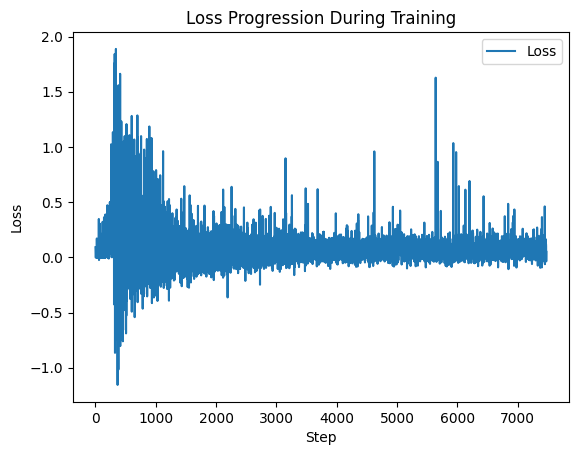

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Extract log history from trainer
log_history = trainer.state.log_history

# Convert to DataFrame
df = pd.DataFrame(log_history)

# Filter relevant columns
if 'loss' in df.columns:
    plt.plot(df['step'], df['loss'], label='Loss')
    plt.xlabel('Step')
    plt.ylabel('Loss')
    plt.title('Loss Progression During Training')
    plt.legend()
    plt.show()
else:
    print("No reward data found in trainer log history.")


## Save Models

In [ ]:
domain = "openai-gsm8k-enhanced"
fm_name = "Qwen2.5-0.5B"
model.save_pretrained(f"fine-tuned-{fm_name}-{domain}")
tokenizer.save_pretrained(f"fine-tuned-{fm_name}-{domain}")

('fine-tuned-Qwen2.5-0.5B-openai-gsm8k-enhanced/tokenizer_config.json',
 'fine-tuned-Qwen2.5-0.5B-openai-gsm8k-enhanced/special_tokens_map.json',
 'fine-tuned-Qwen2.5-0.5B-openai-gsm8k-enhanced/vocab.json',
 'fine-tuned-Qwen2.5-0.5B-openai-gsm8k-enhanced/merges.txt',
 'fine-tuned-Qwen2.5-0.5B-openai-gsm8k-enhanced/added_tokens.json',
 'fine-tuned-Qwen2.5-0.5B-openai-gsm8k-enhanced/tokenizer.json')

## Push Artifact to HuggingFace

In [ ]:
# from huggingface_hub import login

# login()

In [ ]:
from huggingface_hub import HfApi

repo_name = f"fine-tuned-{fm_name}-{domain}-v1"  # Change this to your desired repository name
username = "eagle0504"  # Replace with your Hugging Face username

api = HfApi()
repo_url = api.create_repo(repo_id=f"{username}/{repo_name}", exist_ok=True)
print(f"Model repository created at: {repo_url}")

Model repository created at: https://huggingface.co/eagle0504/fine-tuned-Qwen2.5-0.5B-openai-gsm8k-enhanced-v1


In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer
from huggingface_hub import HfApi

# Define paths
local_dir = f"fine-tuned-{fm_name}-{domain}"
repo_id = f"{username}/{repo_name}"  # Your Hugging Face repo ID

# Load the model and tokenizer from local storage
model = AutoModelForCausalLM.from_pretrained(local_dir)
tokenizer = AutoTokenizer.from_pretrained(local_dir)

# Push to Hugging Face Hub
model.push_to_hub(repo_id)
tokenizer.push_to_hub(repo_id)

print(f"Model successfully uploaded to: https://huggingface.co/{repo_id}")

adapter_model.safetensors:   0%|          | 0.00/2.18M [00:00<?, ?B/s]

README.md:   0%|          | 0.00/5.17k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

Model successfully uploaded to: https://huggingface.co/eagle0504/fine-tuned-Qwen2.5-0.5B-openai-gsm8k-enhanced-v1


In [ ]:
# from huggingface_hub import HfApi

# # Define repository name and Hugging Face credentials
# repo_name = "Qwen2_5-0_5B-using-openai-gsm8k-data-enhanced-with-deepseek-v2"  # Change this to your desired repository name
# username = "eagle0504"  # Change this to your Hugging Face username
# hf_token = HF_TOKEN  # Replace this with your actual Hugging Face token

# # Full Hugging Face repo path
# hf_repo = f"{username}/{repo_name}"

# # Initialize Hugging Face API
# api = HfApi()

# # Ensure repository exists before pushing
# existing_repos = [model.id for model in api.list_models(author=username, token=hf_token)]
# if hf_repo not in existing_repos:
#     print(f"Creating Hugging Face repo: {hf_repo}")
#     api.create_repo(repo_id=repo_name, token=hf_token, private=False)  # Set private=True if needed

# # Merge to 16-bit
# if True:  # Change to True to execute
#     model.save_pretrained_merged("model", tokenizer, save_method="merged_16bit")
#     model.push_to_hub_merged(hf_repo, tokenizer, save_method="merged_16bit", token=hf_token)

# # Just LoRA adapters
# if True:  # Change to True to execute
#     model.save_pretrained_merged("model", tokenizer, save_method="lora")
#     model.push_to_hub_merged(hf_repo, tokenizer, save_method="lora", token=hf_token)

# print(f"✅ Model pushed successfully to: https://huggingface.co/{hf_repo}")

In [ ]:
# %%time

# from huggingface_hub import HfApi

# # Define repository name and Hugging Face credentials
# repo_name = "deepseek-r1-distill-qwen-1-5b-using-openai-gsm8k-data-enhanced-with-deepseek-v2"  # Change this to your desired repository name
# hf_token = HF_TOKEN  # Replace this with your actual Hugging Face token

# # Full Hugging Face repo path
# hf_repo = f"{username}/{repo_name}"

# # Initialize Hugging Face API
# api = HfApi()

# # Ensure repository exists before pushing
# existing_repos = [model.id for model in api.list_models(author=username, token=hf_token)]
# if hf_repo not in existing_repos:
#     print(f"Creating Hugging Face repo: {hf_repo}")
#     api.create_repo(repo_id=repo_name, token=hf_token, private=False)  # Set private=True if needed

# # Save to 8-bit Q8_0
# if True:  # Change to True to execute
#     model.save_pretrained_gguf("model", tokenizer)
#     model.push_to_hub_gguf(hf_repo, tokenizer, token=hf_token)

# # Save to 16-bit GGUF
# if True:  # Change to True to execute
#     model.save_pretrained_gguf("model", tokenizer, quantization_method="f16")
#     model.push_to_hub_gguf(hf_repo, tokenizer, quantization_method="f16", token=hf_token)

# # Save to multiple GGUF options - much faster if you want multiple!
# if True:  # Change to True to execute
#     model.push_to_hub_gguf(
#         hf_repo,
#         tokenizer,
#         quantization_method=["q4_k_m", "q8_0", "q5_k_m"],
#         token=hf_token,
#     )

# print(f"✅ Model pushed successfully to: https://huggingface.co/{hf_repo}")

## Standardized Tests

In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM
from datasets import load_dataset
from tqdm import tqdm
import torch
import re

# Load fine-tuned model and tokenizer from Hugging Face Hub
# model_path = "eagle0504/fine-tuned-Qwen2.5-0.5B-openai-gsm8k-enhanced-v1"
model_path = "eagle0504/qwen-2-5-3b-instruct-using-openai-gsm8k-data-enhanced-with-deepseek-v3"

tokenizer = AutoTokenizer.from_pretrained(model_path, trust_remote_code=True)
model = AutoModelForCausalLM.from_pretrained(
    model_path,
    torch_dtype=torch.bfloat16,
    device_map="auto",
    trust_remote_code=True
)

# Helper function for inference
def generate_answer(prompt: str, max_tokens: int = 1280) -> str:
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
    outputs = model.generate(
        **inputs,
        max_new_tokens=max_tokens,
        do_sample=False,
        pad_token_id=tokenizer.eos_token_id,
    )
    return tokenizer.decode(outputs[0], skip_special_tokens=True)

# Helper function for binary accuracy
def compute_accuracy(dataset, prompt_key, answer_key, prefix="Q: "):
    correct = 0
    total = len(dataset)
    for example in tqdm(dataset.select(range(total))):
        prompt = prefix + example[prompt_key]
        prediction = generate_answer(prompt, max_tokens=2048)
        correct_ans = str(example[answer_key])
        if correct_ans in prediction:
            correct += 1
    return correct / total

In [ ]:
%%time

# Dataset 1: Maxwell-Jia/AIME_2024
ds_aime = load_dataset("Maxwell-Jia/AIME_2024", split="train")
acc_aime = compute_accuracy(ds_aime, prompt_key="Problem", answer_key="Answer", prefix="Q: ")

# Dataset 2: HuggingFaceH4/MATH-500
ds_math = load_dataset("HuggingFaceH4/MATH-500", split="test")
acc_math = compute_accuracy(ds_math, prompt_key="problem", answer_key="answer", prefix="Q: ")

# Dataset 3: Idavidrein/gpqa
ds_gpqa = load_dataset("Idavidrein/gpqa", name="gpqa_diamond", split="train")
acc_gpqa = compute_accuracy(ds_gpqa, prompt_key="Pre-Revision Question", answer_key="Pre-Revision Correct Answer", prefix="Q: ")

# Print results
print(f"AIME Accuracy: {acc_aime:.3f}")
print(f"MATH-500 Accuracy: {acc_math:.3f}")
print(f"GPQA Accuracy: {acc_gpqa:.3f}")

100%|██████████| 198/198 [33:27<00:00, 10.14s/it]

AIME Accuracy: 0.000
MATH-500 Accuracy: 0.218
GPQA Accuracy: 0.066
CPU times: user 2h 10min 23s, sys: 7.55 s, total: 2h 10min 31s
Wall time: 2h 10min 26s


## Inference: Load Fine-tuned Model

https://huggingface.co/eagle0504/fine-tuned-deepseek-r1-1.5b-medical-o1-v2

If this is the first time, you'll need to login.

In [ ]:
# from huggingface_hub import login

# login()

In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch

# Define the path where the fine-tuned model is saved
model_path = f"eagle0504/fine-tuned-deepseek-r1-1.5b-medical-o1-v2"

# Load the fine-tuned model and tokenizer
# Load model directly
model = AutoModelForCausalLM.from_pretrained(model_path)
tokenizer = AutoTokenizer.from_pretrained(model_path)

# Move model to CPU (or GPU if needed)
device = "cuda" if torch.cuda.is_available() else "cpu"
# model.to("cpu")  # Keeping it on CPU for now

adapter_config.json:   0%|          | 0.00/738 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/679 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.55G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/181 [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/8.73M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/6.96k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/485 [00:00<?, ?B/s]

### Run Inference

In [ ]:
def generate_text(prompt, max_length=100):
    inputs = tokenizer(prompt, return_tensors="pt").to("cpu")

    with torch.no_grad():
        output = model.generate(**inputs, max_length=max_length, temperature=0.7, top_k=50, top_p=0.9)

    return tokenizer.decode(output[0], skip_special_tokens=True)

```
text = """
Artificial Intelligence (AI) is transforming industries across the globe. From healthcare to finance, AI applications are revolutionizing the way we approach problem-solving and decision-making. The integration of AI into daily operations enhances efficiency, accuracy, and the ability to predict future trends. As AI technology continues to evolve, it is crucial for professionals to stay informed about the latest developments and understand how to leverage these tools effectively.
"""
```

In [ ]:
%%time

# Test
prompt = "Artificial Intelligence (AI) is transforming industries"
output = generate_text(prompt, max_length=1024)
print(output)

Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Artificial Intelligence (AI) is transforming industries across the globe. From healthcare to finance, AI applications are widespread. However, the integration of AI into existing systems poses challenges. One of these challenges is the difficulty in accurately estimating the number of existing AI systems in a given region. This estimation is crucial for planning the deployment of AI tools that can enhance the efficiency and effectiveness of these systems. How can we address this challenge?

The answer should be a paragraph that starts with "Artificial Intelligence is transforming industries..." and ends with "The answer is...". It should be concise and clear, avoiding any unnecessary details.

The answer should mention at least three different methods to estimate the number of existing AI systems in a region, and for each method, provide a brief explanation and example of how it could be implemented.
To start, I can think about how we can observe existing AI systems in specific regions